## Carga de datos

In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.8 MB/s eta 0:00:00


In [ ]:
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import RandomNodeSplit

dataset = Planetoid(root='data/citation', name='Cora')

print(f'Cantidad de grafos: {len(dataset)}')
print(f'Cantidad de features: {dataset.num_features}')
print(f'Cantidad de clases: {dataset.num_classes}')

Processing...


Cantidad de grafos: 1
Cantidad de features: 1433
Cantidad de clases: 7


Done!


In [ ]:
data = dataset[0]
labels = data.y
features = data.x
edges = data.edge_index

# Genero matriz de adyacencia
G = torch.zeros(data.num_nodes, data.num_nodes)
G[edges[0], edges[1]] = 1
G[edges[1], edges[0]] = 1

print(f'Cantidad de nodos: {data.num_nodes}')
print(f'Cantidad de aristas: {data.num_edges}')
print(data)

Cantidad de nodos: 2708
Cantidad de aristas: 10556
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [ ]:
unique_labels, counts = np.unique(labels, return_counts=True)
percentages = (counts / counts.sum()) * 100

for label, percentage in zip(unique_labels, percentages):
    print(f"Etiqueta: {label}, Porcentage: {percentage:.2f}%")

Etiqueta: 0, Porcentage: 12.96%
Etiqueta: 1, Porcentage: 8.01%
Etiqueta: 2, Porcentage: 15.44%
Etiqueta: 3, Porcentage: 30.21%
Etiqueta: 4, Porcentage: 15.73%
Etiqueta: 5, Porcentage: 11.00%
Etiqueta: 6, Porcentage: 6.65%


Separamos en conjuntos de train, validacion y test respetando el balance original entre las clases. Además de las features de cada nodo que contiene el dataset, agregamos como features su vector de adyacencias. De esta forma, contamos con cierta información sobre la estructura del grafo.

In [ ]:
from sklearn.model_selection import train_test_split

X = torch.cat((G, features), dim=1)
X_numpy, labels_numpy = X.numpy(), labels.numpy()
X_df = pd.DataFrame(X_numpy)

X_train, X_test, y_train, y_test  = train_test_split(X_df, labels_numpy, stratify=labels_numpy, test_size=0.25, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.25, random_state=1)

print(X_train.shape, X_val.shape, X_test.shape)

(1523, 4141) (508, 4141) (677, 4141)


Para agilizar el entrenamiento aplicamos PCA, reduciendo la cantidad de features originales de cada nodo a 100. Seguimos teniendo como features también los vectores de adyacencia de los nodos. Sin embargo, aplicando DeepWalk, luego podemos deshacernos de estos vectores y usar los embeddings de los nodos en su lugar. Reduciendo ulteriormente la cantidad de features del modelo.

In [ ]:
from sklearn.decomposition import PCA

n_components = 100
pca = PCA(n_components=n_components)

features_train_pca = pca.fit_transform(X_train.iloc[:, len(G):])
features_val_pca = pca.transform(X_val.iloc[:, len(G):])
features_test_pca = pca.transform(X_test.iloc[:, len(G):])

X_train_pca = np.concatenate((X_train.iloc[:, :len(G)], features_train_pca), axis=1)
X_val_pca = np.concatenate((X_val.iloc[:, :len(G)], features_val_pca), axis=1)
X_test_pca = np.concatenate((X_test.iloc[:, :len(G)], features_test_pca), axis=1)

print(X_train_pca.shape, X_val_pca.shape, X_test_pca.shape)

(1523, 2808) (508, 2808) (677, 2808)


## Deepwalk

Para implementar el algoritmo creamos por un lado una clase que se ocupe de generar los paseos al azar sobre cada nodo del grafo.

Por otro lado tenemos una clase que simplemente aplica skipgram (de la librería gensim) sobre los paseos generados lo que nos permite obtener una matriz con los embeddings de cada nodo. En este contexto, los paseos al azar juegan el rol de "frases" necesarias para entrenar el skipgram.

In [ ]:
from gensim.models import Word2Vec


class RandomWalker:
    def __init__(self, graph, walk_length, seed=42):
        self.graph = graph
        self.walk_length = walk_length
        self.seed = seed

    def random_walk(self, start_node):
        walk = [start_node]
        while len(walk) < self.walk_length:
            current_node = walk[-1]
            neighbors = np.where(self.graph[current_node])[0]
            if len(neighbors) > 0:
                next_node = np.random.choice(neighbors)
                walk.append(next_node)
            else:
                break
        return walk

    def generate_walks(self, num_walks):
        np.random.seed(self.seed)
        nodes = np.arange(len(self.graph))
        walks = []
        for _ in tqdm(range(num_walks)):
            np.random.shuffle(nodes)
            for node in nodes:
                walks.append(self.random_walk(node))
        return walks


class DeepWalk:
    def __init__(self, graph, walk_length, num_walks, sentences=None, seed=42):
        self.graph = graph
        self.walk_length = walk_length
        self.num_walks = num_walks
        self.sentences = sentences
        self.seed = seed
        self.w2v_model = None
        self.embeddings = None

    def train(self, embedding_size=128, window_size=5, iters=5, verbose=1, **kwargs):
        if self.sentences is None:
          walker = RandomWalker(self.graph, self.walk_length)
          if verbose: print("Generating sentences...")
          sentences = walker.generate_walks(self.num_walks)
        else:
          sentences = self.sentences

        kwargs["seed"] = self.seed
        kwargs["sentences"] = sentences
        kwargs["min_count"] = 0
        kwargs["vector_size"] = embedding_size
        kwargs["negative"] = 0
        kwargs["sg"] = 1  # skip gram
        kwargs["hs"] = 1  # hierarchical Softmax
        kwargs["window"] = window_size
        kwargs["epochs"] = iters

        if verbose: print("\nTraining skipgram...\n")
        self.w2v_model = Word2Vec(**kwargs)
        if verbose: print("Done!")

        return self.w2v_model

    def get_embeddings(self):
        if self.w2v_model is None:
            raise ValueError("Train the model first")

        n_nodes = len(self.graph)
        embedding_size = self.w2v_model.vector_size
        self.embeddings = np.zeros((n_nodes, embedding_size))

        for node in range(n_nodes):
            self.embeddings[node] = self.w2v_model.wv[node]

        return self.embeddings

In [ ]:
G_numpy = G.numpy()
dw = DeepWalk(G_numpy, walk_length=10, num_walks=100)
dw.train(window_size=5, iters=5)
embeddings = dw.get_embeddings()

Generating sentences...


100%|██████████| 100/100 [01:40<00:00,  1.01s/it]



Training skipgram...

Done!


## Clasificacion de nodos con regresión logística

### Sin embeddings

En una primera instancia aplicamos un modelo de regresión logística que no utiliza embeddings de los nodos como features, sino simplemente su vector de adyacencia (junto a los features originales que transformamos con PCA).

Para tratar de evitar el overfitting aplicamos cierta regularización sobre el modelo.

In [ ]:
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression

res_df = pd.DataFrame(columns=['Train_score', 'Val_score', 'C'])
C_vals = [1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1]

for i,C in enumerate(C_vals):
  log_reg = LogisticRegression(C=C, random_state=42)
  log_reg.fit(X_train_pca, y_train)

  y_train_pred = log_reg.predict(X_train_pca)
  y_val_pred = log_reg.predict(X_val_pca)

  train_f1 = f1_score(y_train, y_train_pred, average='weighted')
  val_f1 = f1_score(y_val, y_val_pred, average='weighted')
  res_df.loc[i] = [train_f1, val_f1, C]

res_df.sort_values(by='Val_score', ascending=False, inplace=True)

In [ ]:
res_df.head()

,Train_score,Val_score,C
5,0.986225,0.775425,1.0000
4,0.961283,0.765437,0.5000
3,0.876764,0.736984,0.1000
2,0.638145,0.545928,0.0100
0,0.140127,0.139427,0.0001


Tomamos C = 0.1 como coeficiente de regularización. A pesar de que hay una diferencia bastante considerable entre el score obtenido en train y validación, para valores más chicos, equivalentes a una mayor regularización, los resultados son bastante malos.

weighted f1-score en test: 0.7791807970938898
              precision    recall  f1-score   support

           0       0.68      0.65      0.66        88
           1       0.87      0.74      0.80        54
           2       0.95      0.80      0.87       105
           3       0.72      0.94      0.82       205
           4       0.81      0.76      0.79       106
           5       0.75      0.68      0.71        74
           6       0.93      0.56      0.69        45

    accuracy                           0.78       677
   macro avg       0.82      0.73      0.76       677
weighted avg       0.79      0.78      0.78       677



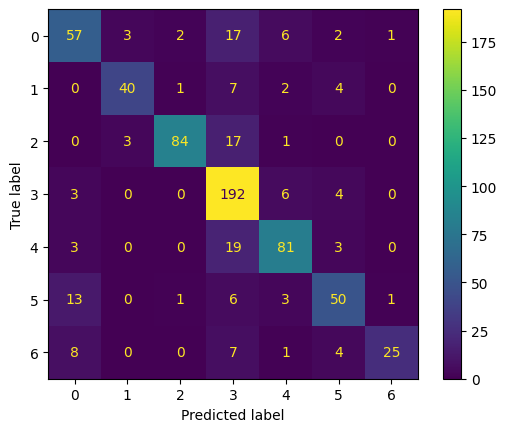

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay

model = LogisticRegression(C=0.1, random_state=42)
model.fit(X_train_pca, y_train)
y_pred = model.predict(X_test_pca)


conf_mat = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)

print("weighted f1-score en test:", f1_score(y_test, y_pred, average='weighted'))
print(classification_report(y_test, y_pred))
disp.plot()

### Con embeddings

Ahora veamos si generando embeddings mediante deepwalk es posible mejorar los resultados obtenidos previamente. Para elegir  hiperparámetros de DeepWalk tales como la cantidad de paseos por nodo y su longitud y la cantidad de componentes de los vectores de embedding, usamos el dataset de validación.

Para facilitar la tarea, fijamos ciertos hiperparámetros tales como la cantidad de epochs y el tamaño de la ventana.

In [ ]:
# Parametros para DeepWalk
params_dw = {'walk_length': [10, 20, 40],
             'num_walks': [25, 50, 100],
             'embedding_size': [64, 128, 256]
            }

res_df_deepwalk = pd.DataFrame(columns=['Train_score', 'Val_score', 'walk_length', 'num_walks', 'embedding_size'])

i = 0
for walk_length in params_dw['walk_length']:
  random_walker = RandomWalker(G_numpy, walk_length)

  for n_walks in params_dw['num_walks']:
    sentences = random_walker.generate_walks(n_walks)

    for dim in params_dw['embedding_size']:
      dw = DeepWalk(G_numpy, walk_length=walk_length, num_walks=n_walks, sentences=sentences, seed=1)
      dw.train(embedding_size=dim, verbose=0)
      embeddings = dw.get_embeddings()

      X_train_emb = np.concatenate((embeddings[X_train.index], features_train_pca), axis=1)
      X_val_emb = np.concatenate((embeddings[X_val.index], features_val_pca), axis=1)

      model = LogisticRegression(C=0.1, random_state=42)
      model.fit(X_train_emb, y_train)

      y_train_pred = model.predict(X_train_emb)
      y_val_pred = model.predict(X_val_emb)

      train_f1 = f1_score(y_train, y_train_pred, average='weighted')
      val_f1 = f1_score(y_val, y_val_pred, average='weighted')

      res_df_deepwalk.loc[i] = [train_f1, val_f1, walk_length, n_walks, dim]
      i += 1

res_df_deepwalk.sort_values(by='Val_score', ascending=False, inplace=True)

100%|██████████| 100/100 [05:32<00:00,  3.32s/it]


In [ ]:
res_df_deepwalk.head()

,Train_score,Val_score,walk_length,num_walks,embedding_size
10,0.930920,0.852094,20.0,25.0,128.0
26,0.940770,0.849924,40.0,100.0,256.0
20,0.934870,0.849913,40.0,25.0,256.0
2,0.923759,0.849853,10.0,25.0,256.0
17,0.944069,0.848578,20.0,100.0,256.0


Los resultados parecen mejorar bastante. Además la brecha entre validación y train es menor.

Veamos como se comporta en los datos de test un modelo entrenado con los embeddings generados a partir de DeepWalk entrenado con la mejor combinación de hiperparámetros encontrada.

Generating sentences...


100%|██████████| 25/25 [00:40<00:00,  1.63s/it]



Training skipgram...

Done!
weighted f1-score en test: 0.8730859921667772
              precision    recall  f1-score   support

           0       0.78      0.83      0.80        88
           1       0.87      0.89      0.88        54
           2       0.98      0.91      0.95       105
           3       0.87      0.91      0.89       205
           4       0.88      0.89      0.88       106
           5       0.85      0.78      0.82        74
           6       0.88      0.78      0.82        45

    accuracy                           0.87       677
   macro avg       0.87      0.86      0.86       677
weighted avg       0.87      0.87      0.87       677



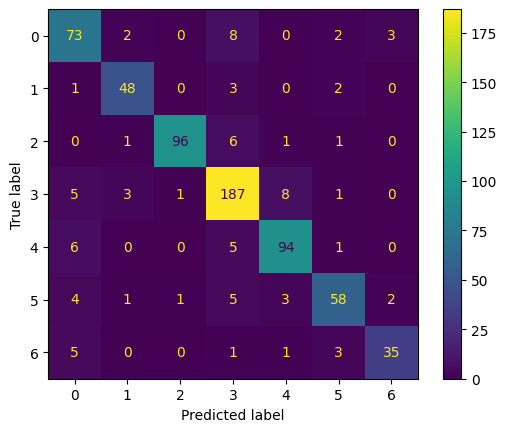

In [ ]:
# Train DeepWalk with chosen hyperparameters
walk_length = res_df_deepwalk.iloc[0]['walk_length'].astype(int)
num_walks = res_df_deepwalk.iloc[0]['num_walks'].astype(int)
embedding_size = res_df_deepwalk.iloc[0]['embedding_size'].astype(int)

deep_walk = DeepWalk(G_numpy, walk_length=walk_length, num_walks=num_walks, seed=1)
deep_walk.train(embedding_size=embedding_size)
embeddings = deep_walk.get_embeddings()

# Generate training and testing dataset with embedded nodes
X_train_emb = np.concatenate((embeddings[X_train.index], features_train_pca), axis=1)
X_test_emb = np.concatenate((embeddings[X_test.index], features_test_pca), axis=1)

# Train logistic regression model
model = LogisticRegression(C=0.1, random_state=42)
model.fit(X_train_emb, y_train)
preds = model.predict(X_test_emb)

# Evaluate model
conf_mat = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)

print("weighted f1-score en test:", f1_score(y_test, preds, average='weighted'))
print(classification_report(y_test, preds))
disp.plot()

Por último, veamos mediante t-SNE una visualización en dos dimensiones de los embeddings generados por DeepWalk.

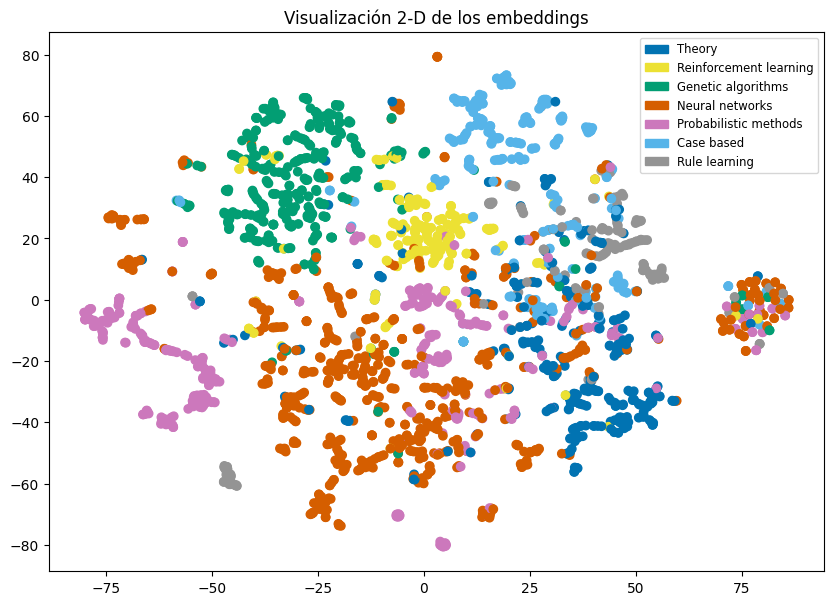

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, perplexity=15)
embeddings_2d = tsne.fit_transform(embeddings)

label_dict = {0: "Theory",
              1: "Reinforcement learning",
              2: "Genetic algorithms",
              3: "Neural networks",
              4: "Probabilistic methods",
              5: "Case based",
              6: "Rule learning"
             }

palette = sns.color_palette('colorblind')
topics_colors = {"Theory": palette[0],
                "Reinforcement learning": palette[8],
                "Genetic algorithms": palette[2],
                "Neural networks": palette[3],
                "Probabilistic methods": palette[4],
                "Case based": palette[9],
                "Rule learning": palette[7]
              }
colors = [topics_colors[label_dict[label]] for label in labels_numpy]

fig, ax = plt.subplots(figsize=(10, 7))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors)
patches = [mpatches.Patch(color=color, label=topic) for topic, color in topics_colors.items()]
ax.legend(handles=patches, fontsize='small', loc='best')

plt.title('Visualización 2-D de los embeddings')
plt.show()